<a href="https://dacon.io/competitions/official/136/overview/description/">대회링크</a>

# 대출 상점 총 매출 예측 경진대회

한국의 약 2,000개 상점의 신용카드 거래 내역이 제공됩니다. card_id를 기준으로 샘플링되었으며, amount의 단위는 KRW가 아닙니다. 테스트 파일에서 각 상점의 마지막 매출 발생일 다음 날부터 100일 후까지 매출의 총합을 예측해야 합니다.

 

예측한 금액만큼 100일간 대출을 진행합니다. 만약 예측한 금액보다 실제 매출이 적게 발생한다면 원금에 손실을 보게 됩니다. 실제 매출이 예측한 금액 이상으로 발생한다면, 연이율 13%의 이자가 발생합니다.



[Data]

train.csv - 카드 매출 내역, 2016-08-01부터 2018-07-31까지.


test.csv - train.csv랑 같은 형식. test.csv랑 train.csv의 store_id가 같아도 같은 상점인 것은 아님.

(월에 최소 5일 이상 데이터가 있는 상점만을 문제에 포함.)

- store_id : 각 파일에서의 상점 고유 번호 (해당기한 내 개업 혹은 폐업한 상점도 있음)

- date: 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출 금액, 음수인 경우 취소 거래
- installments : 할부 개월 수. 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holiday: 1이면 공휴일, 0이면 공휴일 아님


submission.csv – store_id와 total_sales 두 개의 열로 구성. store_id는 test.csv의 store_id와 대응.

# 접근방법

1. 가게마다 주 단위로 자른다
2. 주단위로 다음 주의 값을 예측한다

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')
from datetime import timedelta

In [228]:
def load_data():
    train = pd.read_csv('C:\kaggle_data/credit/train.csv')
    test = pd.read_csv('C:\kaggle_data/credit/test.csv')
    ss = pd.read_csv('C:\kaggle_data/credit/submission.csv')
    return train, test, ss
train, test, ss = load_data()

In [229]:
display(train.head(5))
display(test.head(5))

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-08-01,00:28:15,bf33518373,125,NaN,0,0
1,0,2016-08-01,01:09:58,7a19a3a92f,90,NaN,0,0
2,0,2016-08-01,01:47:24,6f9fd7e241,150,NaN,0,0
3,0,2016-08-01,17:54:43,8bcf1d61b2,362,NaN,0,0
4,0,2016-08-01,18:48:53,6a722ce674,125,NaN,0,0


In [230]:
train.info(verbose=True, null_counts=True) # non-nullcounts가 안 나오는 경우

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3362796 entries, 0 to 3362795
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   store_id      3362796 non-null  int64  
 1   date          3362796 non-null  object 
 2   time          3362796 non-null  object 
 3   card_id       3362796 non-null  object 
 4   amount        3362796 non-null  int64  
 5   installments  16860 non-null    float64
 6   days_of_week  3362796 non-null  int64  
 7   holyday       3362796 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 205.2+ MB


In [231]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473392 entries, 0 to 473391
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   store_id      473392 non-null  int64  
 1   date          473392 non-null  object 
 2   time          473392 non-null  object 
 3   card_id       473392 non-null  object 
 4   amount        473392 non-null  int64  
 5   installments  1779 non-null    float64
 6   days_of_week  473392 non-null  int64  
 7   holyday       473392 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 28.9+ MB


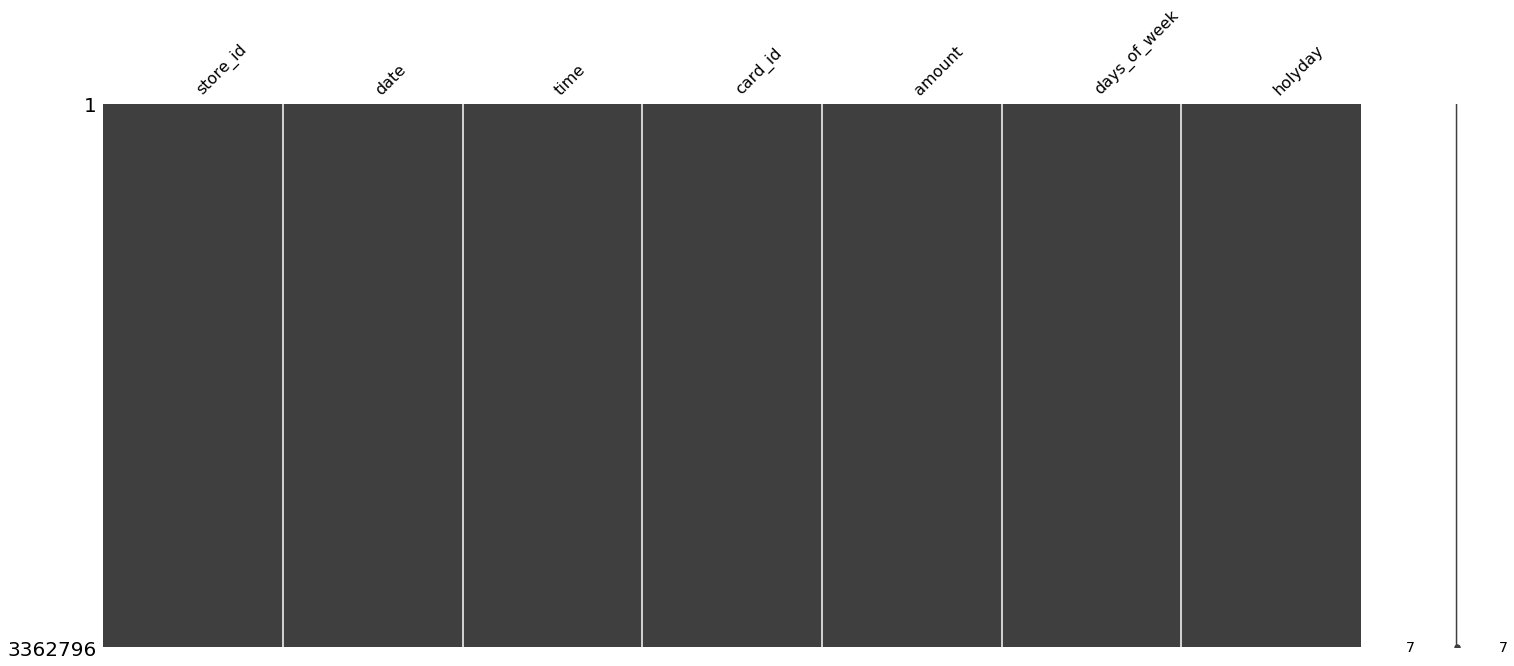

In [232]:
msno.matrix(train[['store_id', 'date', 'time', 'card_id', 'amount', 'days_of_week', 'holyday']])

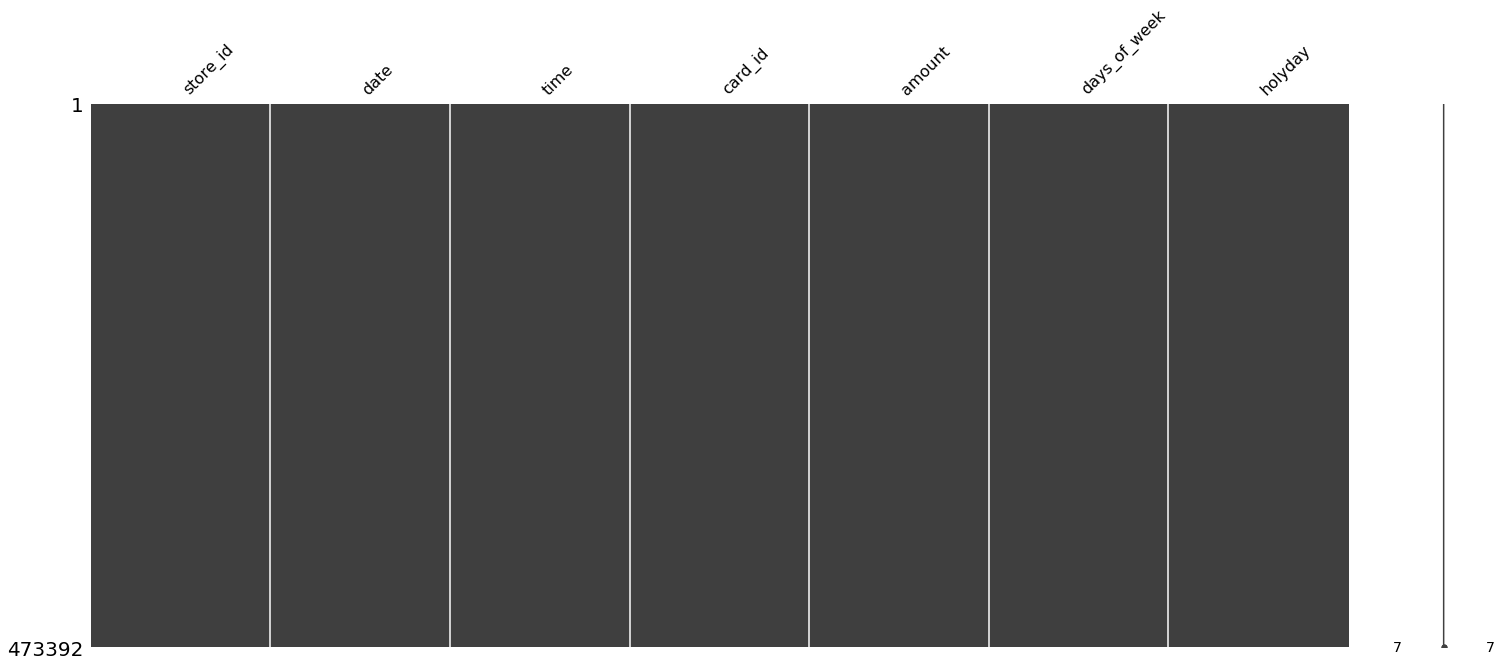

In [233]:
msno.matrix(test[['store_id', 'date', 'time', 'card_id', 'amount', 'days_of_week', 'holyday']])

# 7일 단위로 resampling
- 2016년 8월 1일은 월요일
- resample 후 나오는 값의 의미는 index까지의 집계

# 함수화
- df를 넣어준다
- 필요없는 칼럼 드랍
- date로 인덱싱
- store_id별로 for문을 돌린다
    - 주단위 집계한다
    - year, month, day로 columns을 나눠서 리턴
- lst에 append해둔다
- concat하여 반환한다

In [234]:
def resam_1w(df):
    df = df.drop(['card_id','time','days_of_week','holyday','installments'],1)
    df['date_idx'] = pd.DatetimeIndex(df['date'])
    df = df.set_index('date_idx')
    store_lst = []
    for store_id in df['store_id'].unique():
    
        temp = df[df['store_id']==store_id]
        temp_0 = temp['amount'].resample('1W').sum()
        temp_0 = pd.DataFrame(temp_0)
        temp_0['target'] = temp_0['amount'].shift(-1).fillna(0).astype('int')
        temp_0 = temp_0.reset_index()
        
        temp_0['year'], temp_0['month'], temp_0['day'] = 0,0,0
        for i in range(len(temp_0)):
            temp_0.loc[i,'year'] = temp_0['date_idx'][i].year
            temp_0.loc[i,'month'] = temp_0['date_idx'][i].month
            temp_0.loc[i, 'day'] = temp_0['date_idx'][i].day
        temp_0['store_id'] = store_id
        temp_0['counts'] = len(temp_0)
        store_lst.append(temp_0)
        
    return pd.concat(store_lst)

In [235]:
%%time
train = resam_1w(train)
test = resam_1w(test)

Wall time: 1min 39s


In [236]:
train

,date_idx,amount,target,year,month,day,store_id,counts
0,2016-12-18,0,83568,2016,12,18,0,86
1,2016-12-25,83568,65464,2016,12,25,0,86
2,2017-01-01,65464,63019,2017,1,1,0,86
3,2017-01-08,63019,72032,2017,1,8,0,86
4,2017-01-15,72032,66665,2017,1,15,0,86
...,...,...,...,...,...,...,...,...
69,2018-07-08,0,1225,2018,7,8,1799,74
70,2018-07-15,1225,1925,2018,7,15,1799,74
71,2018-07-22,1925,300,2018,7,22,1799,74
72,2018-07-29,300,325,2018,7,29,1799,74


In [237]:
train = train.drop('date_idx',1)
train['year'] = train['year'] - 2016
train['day'] = train['day']/31

In [238]:
y = train.pop('target')
train = train[['counts', 'year', 'month', 'day','amount' ]]

In [239]:
# test = test.drop('date_idx',1)
test['year'] = test['year'] - 2016
test['day'] = test['day']/31

In [240]:
import xgboost as xgb
# from sklearn.model_selection import KFold

xgb_reg = xgb.XGBRegressor(random_state=1123, tree_method='gpu_hist')

In [241]:
xgb_reg.fit(train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0)', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             random_state=1123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

# 각 가게마다 규모같은 게 있을테니 총 거래건수를 하나 만들어줘서 넣어야겠다.

# test 예측을 위한 전처리
- store id별로 마지막 날짜를 찾아낸다 last_day
- for 14번
    - last day의 target을 예측한다  # model.predict(temp.tail(1))
    - last day의 year + month + day 를 합쳐서 datetime으로 만들고 +7일
    - {'year': year, month: month, day: day, amount: target, store_id: store_id}
    - 위 딕셔너리를 append

In [242]:
for s_id in test['store_id'].unique():
    temp = test[test['store_id']==s_id]
    for i in range(14):
        last_row = temp.tail(1)
        counts = last_row['counts'].values[0]
        store_id = last_row['store_id'].values[0]
        next_date = (last_row['date_idx'] + timedelta(days=7)).iloc[-1]
        target = xgb_reg.predict(last_row[['counts', 'year', 'month', 'day', 'amount']])
        temp = temp.append({'date_idx':next_date, 
                     'amount':target[0], 
                     'year':next_date.year-2016,
                     'month':next_date.month,
                     'day':next_date.day/31,
                     'store_id': store_id,
                     'counts':counts}, ignore_index=True)
    
    
    ss.iloc[s_id][1] = temp.iloc[-14:]['amount'].sum()*0.7

In [243]:
ss.to_csv('half_baseline.csv',index=False)